## ПРОГНОЗИРОВАНИЕ НАГРУЗКИ ОФИСНЫХ ЗДАНИЙ ДЛЯ ПОВЫШЕНИЯ ЭФФЕКТИВНОСТИ СИСТЕМ УПРАВЛЕНИЯ ЭНЕРГОПОТРЕБЛЕНИЕМ В УСЛОВИЯХ ПАНДЕМИИ COVID-19

### Проблема: <br>
В связи с пандемией COVID-19, переход ряда сотрудников на удаленную работу приобрел стохастический характер, что требует совершенствования используемых подходов к прогнозированию потребления электрической энергии. В связи с этим представляется целесообразным учет дополнительных параметров для прогнозирования.

В рамках задания необходимо подготовить модель машинного обучения, обеспечивающую высокую точность прогнозирования нагрузки офисного здания в условиях пандемии COVID-19. 

### Загрузка библиотек

In [1]:
# подготовка и анализ данных
import os
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from itertools import compress
import datetime
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

# отрисовка
import matplotlib.pyplot as plt
import seaborn as sns
# разметка данных
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
# метрики
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
# модели
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

sns.set(color_codes=True)

### Исходные данные <br>
В качестве исходных данных предоставляются следующие данные:
1.	Датасет building_data.xlsx (данные с датчиков ICP DAS)
2.	Датасет building_data_meters.xlsx (данные с приборов учета)
3.	Датасет с метеоданными (ВДНХ).
4.	Датасет с метеоданными (Шереметьево).

#### Загрузка данных

In [4]:
# данные с датчиков ICP DAS
icp_das = pd.read_excel(os.path.join(os.getcwd(), 'data', 'building_data.xlsx'))

In [5]:
# данные с приборов учета
metering_device = pd.read_excel(os.path.join(os.getcwd(), 'data', 'building_data_meters.xlsx'))

In [47]:
# погода ВДНХ 
vdnh = pd.read_excel(os.path.join(os.getcwd(), 'data', 'VDNH.xls'), header=6)

In [6]:
# погода Шереметьево 
svo = pd.read_excel(os.path.join(os.getcwd(), 'data', 'SVO.xls'), header=6)

#### Обработка данных

##### 1. Данные с датчиков ICP DAS

In [7]:
def icp_process(data):
    '''
    препроцессинг данных с датчиков
    '''
    # копия данных
    df = deepcopy(data)
    # перевод в местное время - UTC+3
    df['time'] = df['time'] + pd.DateOffset(hours=3)

    # содание целевого столбца
    df['target'] = (df['_Bus_1_p_TM1H_mv_val'] + df['_Bus_2_p_TM1H_mv_val'] + 
                    df['_Bus_3_p_TM1H_mv_val'] + df['_Bus_4_p_TM1H_mv_val'])

    # сортировка по времени
    df = df.sort_values(by='time', ascending=True).set_index('time')

    return df

##### 2. Данные с приборов учета

In [8]:
def meter_process(data):
    '''
    препроцессинг данных с приборов учета
    '''
    df = deepcopy(data)
    # перевод в местное время - UTC+3
    df['time'] = df['time'] + pd.DateOffset(hours=3)
    
    return df

##### 3. Датасет с метеоданными (Шереметьево)

In [9]:
def svo_process(data):
    '''
    препроцессинг метеоданных
    '''
    df = deepcopy(data)
    df = df.rename(columns={'Местное время в Шереметьево / им. А. С. Пушкина (аэропорт)': 'time'})
    df['time'] = pd.to_datetime(df['time'])
    
    # разделение показателя общей облачности на 2 подпараметра
    df['c_1'] = df['c'].str.extract('(\d+)\s\w')
    df['c_2'] = df['c'].str.extract('([\w\s]+)')
    
    return df

##### 4. Обобщенный датасет

In [10]:
def merge_data(*args):
    '''
    слияние датасетов
    '''
    # слияение таблиц в единый датасет
    data = args[0]
    for i in range(1, len(args)):
        data = data.merge(args[i], how='left', on='time')
    
    return data

##### 5. Создание списка "лишних" столбцов

In [11]:
# создание списка столбцов на удаление (линейная комбинация целевого столбца)
icp_das_to_drop = ['_Bus_1_p_TM1H_mv_val', '_Bus_2_p_TM1H_mv_val', '_Bus_3_p_TM1H_mv_val',
                   '_Bus_4_p_TM1H_mv_val','_externalGrid_Bus_1_p_TM1H_mv_val', 
                   '_externalGrid_Bus_2_p_TM1H_mv_val', '_externalGrid_Bus_3_p_TM1H_mv_val',
                   '_externalGrid_Bus_4_p_TM1H_mv_val', '_roof_1_Bus_4_p_TM1H_mv_val',
                   '_roof_2_Bus_4_p_TM1H_mv_val', '_roof_Bus_1_p_TM1H_mv_val',
                   '_Accumulator_Bus_1_p_TM1H_mv_val', '_Accumulator_Bus_2_p_TM1H_mv_val', 
                   '_Accumulator_Bus_3_p_TM1H_mv_val', '_Accumulator_Bus_4_p_TM1H_mv_val']

In [12]:
# стлбцы с информацией о качестве показаний приборов/измерений (категориальные)
icp_das_col = icp_das.columns
fil_1 = icp_das.columns.str.endswith('qual')
fil_12 = icp_das.columns.str.contains('onoff')
new_icp_das_col = list(compress(icp_das_col, fil_1))+list(compress(icp_das_col, fil_12))

metering_device_col = metering_device.columns
fil_2 = metering_device.columns.str.endswith('qual')
new_metering_device_col = list(compress(metering_device_col, fil_2))

In [13]:
# столбцы для удаления из датасета погоды
wheather_col = ['P', 'DD', 'ff10', "W'W'", 'Td', 'c']

In [14]:
columns_to_drop = icp_das_to_drop + new_icp_das_col + new_metering_device_col+ wheather_col

##### Дополнительные данные по COVID-19

In [15]:
# количество заражений COVID-19 в Москве (по дням)
covid = pd.read_excel(os.path.join(os.getcwd(), 'data', 'covid.xlsx'),header=None)

In [16]:
covid[0] = pd.to_datetime(covid[0])
covid = covid.rename(columns={0:'time', 1:'covid_cases'})

##### 6. Промежуточный датасет

In [17]:
data = merge_data(icp_process(icp_das), meter_process(metering_device), svo_process(svo), covid)

In [18]:
# удаление "лишних" столбцов
data = data.drop(columns=columns_to_drop)

In [19]:
# сохранить в промежуточный файл
def save_to_file(data, name):
    data.to_csv(os.path.join(os.getcwd(), 'data', f'{name}.csv'))

In [20]:
# save_to_file(data, 'intermediate')
# data = pd.read_csv(os.path.join(os.getcwd(), 'data','intermediate.csv'))

### Задачи

#### 1.Выполнить очистку данных от аномалий (Anomaly detection)

In [21]:
# data.info()

In [22]:
data = data.set_index('time')
# популяция значения на весь день
data['covid_cases'] = data['covid_cases'].groupby(pd.Grouper(freq='D')).ffill()

In [23]:
# заполним недостающие значения
data.loc[:'2020-03','covid_cases'] = data.loc[:'2020-03', 'covid_cases'].fillna(0)

In [24]:
data.shape

(21182, 92)

In [25]:
# фичи с типом данных 'object'
data.select_dtypes('object').head()

,WW,VV,c_1,c_2
time,,,,
2018-03-16 16:00:00,NaN,10.0 и более,1080,Рассеянная
2018-03-16 17:00:00,NaN,10.0 и более,1080,Рассеянная
2018-03-16 18:00:00,NaN,10.0 и более,1470,Рассеянная
2018-03-16 19:00:00,NaN,10.0 и более,1170,Разорванная
2018-03-16 20:00:00,NaN,10.0 и более,NaN,Нет существенной облачности


In [26]:
# исправим тип данных джля фичей VV и c_1 (облачность и направление ветра), остальные удалим
data['VV'] = data['VV'].replace('10.0 и более', 10)

data['c'] = data.apply(lambda row: 0 if row['c_2']=='Нет существенной облачности' else float(row['c_1']), axis=1)
# переведем температуру в Кельвины, чтобы изюавиться от отрицательных значений
data['T'] = data['T'] + 273.15

# также удалим столбец _All_Consumers_p_TM1H_mv_val (повторяет target)
data = data.drop(columns=['WW', 'c_1', 'c_2', '_All_Consumers_p_TM1H_mv_val'])

##### Анализ распределния для фичей

In [390]:
# проверим распределение фичей
f1 = data[list(data.columns[1:13])]
f2 = data[list(data.columns[13:25])]
f3 = data[list(data.columns[25:37])]
f4 = data[list(data.columns[37:49])]
f5 = data[list(data.columns[49:59])]
f6 = data[list(data.columns[60:72])]
f7 = data[list(data.columns[72:84])]
f8 = data[list(data.columns[84:90])]

In [728]:
# f1.hist(bins=80, figsize=[14,14])
# plt.suptitle('Numeric feature distribution')
# plt.show()

In [27]:
# удалим фичи, в которых превалируют нулевые значения
def remove_empty(data):
    '''
    удаление фичей с нулевыми значениями
    '''
    res = []
    target_index = data.columns.get_loc('target')
    
    for col in data.iloc[:, :target_index-1].columns:
        if (data[col].sum()/data[col].count()) > 1:
            res.append(col)
            
    res.append('target')
        
    for col in data.iloc[:, target_index+1:].columns:
        if (data[col].sum()/data[col].count()) > 10:
            res.append(col)
        
    return data[res]
        
data_clean = remove_empty(data)

##### Отсутсвующие значения

In [28]:
def calc_percent_NAs(df):
    '''
    подсчитывает процент пропущенных значений в датафрейме
    '''
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]
# Let's use above function to look at top ten columns with NaNs
calc_percent_NAs(data_clean).tail(8)

,percent
P0,0.011614
U,0.011614
c,0.011614
_Consumers_Bus_4_p_TM1H_mv_val,0.009348
_Consumers_Bus_2_p_TM1H_mv_val,0.008970
_Consumers_Bus_3_p_TM1H_mv_val,0.006845
_Consumers_Bus_1_p_TM1H_mv_val,0.006137
covid_cases,0.001605


##### Целевая переменная

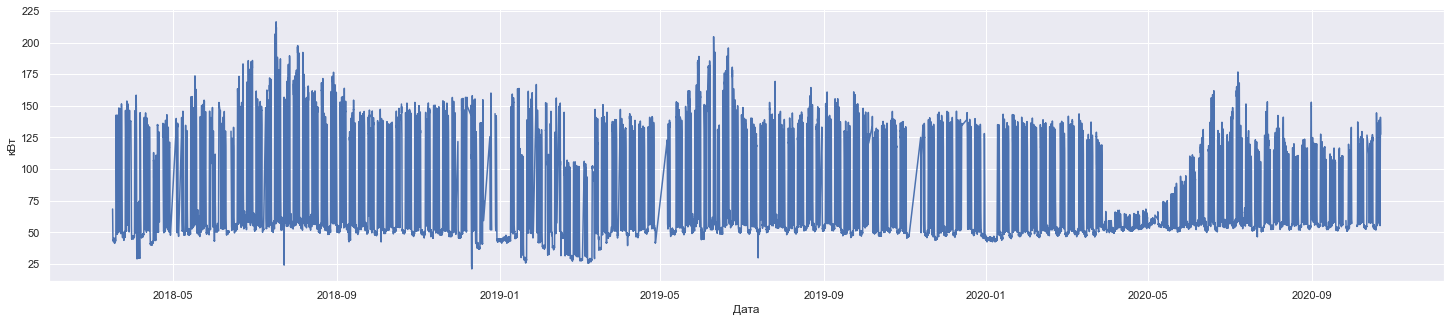

In [29]:
# визуализация
fig, ax = plt.subplots(figsize=(25,5))

ax.plot(data_clean.index, data_clean['target'])
plt.xlabel('Дата')
plt.ylabel('кВт')
plt.show()

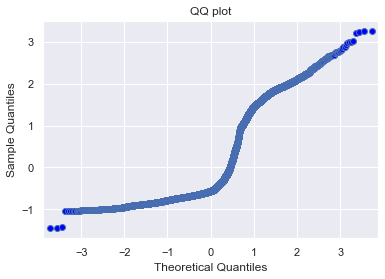

In [30]:
# проверка на нормальное распределение
ddf = data_clean.dropna()

sm.qqplot(ddf.target, fit = True)
plt.title('QQ plot')
plt.show()

Text(0, 0.5, 'Кол-во')

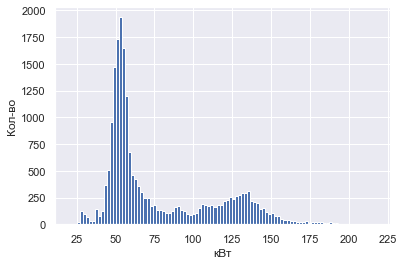

In [31]:
# target имеет биномиальное распределение
data_clean['target'].hist(bins=100);
plt.xlabel('кВт')
plt.ylabel('Кол-во')

##### Выбросы

#### 2. Произвести кластеризацию данных (выявить выходные и праздничные дни, а также дни в которые большая часть сотрудников находилась на удаленной работе). 

##### Кластеризация

##### Корреляции

In [32]:
# разделим датасеты
first_half = data_clean.iloc[:, :data_clean.columns.get_loc('target')+1]
second_half = data_clean.iloc[:, data_clean.columns.get_loc('target'):]

In [33]:
corr_1 =  first_half.corr()
corr_2 =  second_half.corr()

def corr_heatmap(corr_dat, figsize=(10, 10)):
    # маска для верхнего теругольника
    mask = np.zeros_like(corr_dat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # рисунок
    f, ax = plt.subplots(figsize=figsize)

    # кастомная цветовая схема
    # cmap = sns.diverging_palette(240, 10, n=9)

    # отрисовка
    sns.heatmap(corr_dat, mask=mask, cmap='BrBG', vmax=1, vmin=-1, center=0, square=True, linewidths=.5)
    plt.show()

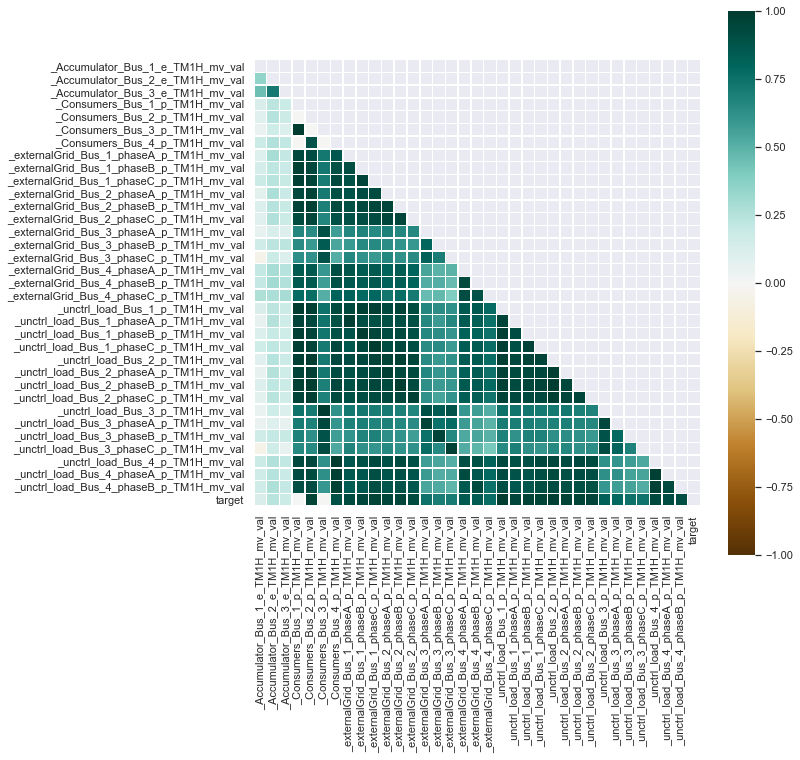

In [34]:
corr_heatmap(corr_1)

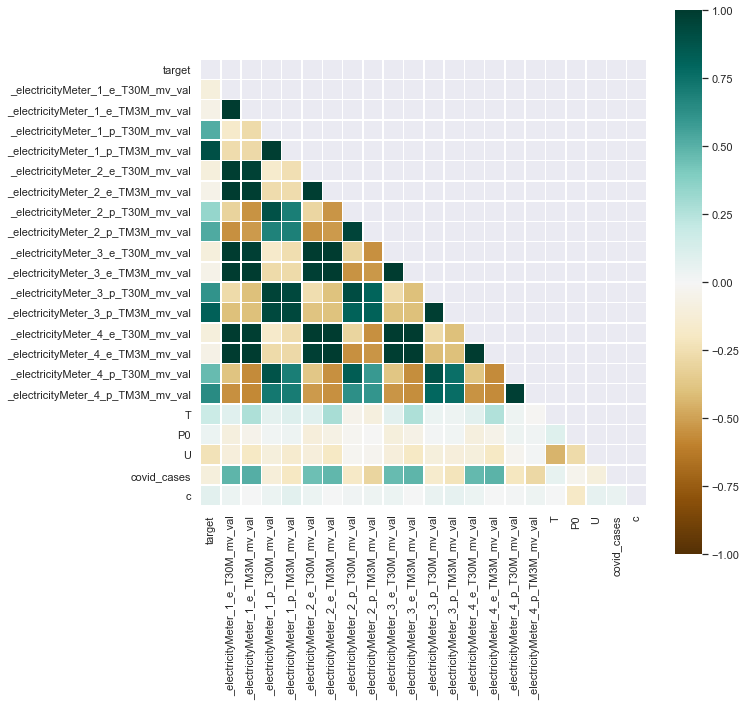

In [35]:
corr_heatmap(corr_2)

In [36]:
# отбор фичей по шкале Чеддока
chaddock_dict={'Functional':(0.99,1),
               'Strong':(0.9,0.99),
               'Close':(0.7,0.9),
               'Noticable':(0.5,0.7),
               'Moderate':(0.3,0.5),
               'Weak':(0.1,0.3),
               'None':(0,0.1)}

def chaddock(df, correlation='Strong', target='target', mode='dataframe'):
    '''returns feature name or builds feature-target_parameter scatterplot (if mode="plot")
    for specified correlation scale in a given dataset'''
    left = chaddock_dict[correlation][0]
    right = chaddock_dict[correlation][1]
    features = list()
    for i in df.columns[:-1]:
        curr_corr = df[i].corr(df[target])
        if (abs(curr_corr) > left) & (abs(curr_corr) < right):
            if mode == 'plot':
                sns.scatterplot(x=target, y=i, data=df)
                print('Correlation coefficient ' + str(curr_corr))
                plt.title('Relationship between target parameter and '+str(i).upper())
                plt.show()
            else:
                features.append(i)
    if mode == 'dataframe':
        return pd.DataFrame({'Features':features})

#### 3. Построить и обучить модель прогнозирования, которая позволяет формировать почасовой прогноз на завтрашний день (прогноз формируется в 00-00 часов). 

- Необходимо формировать почасовой прогноз на следующий день. Т.е. каждый день ровно в 00:00 необходимо определить 24 числа – значения потребления на следующий день. При этом есть информация о потреблении за все предыдущие дни, но очевидно нет информации из будущего.
- Метрику определим, как среднее RMSE за все дневные часы в прогнозном интервале (т.е. с 7:00 до 22:00 МСК). Прогноз ночного потребления нам неинтересен. Обратите внимание, в датасете время в UTC.

Для пункта 3) задания необходимо формировать почасовой прогноз на следующий день. Т.е. каждый день ровно в 00:00 необходимо определить 24 числа – значения потребления на следующий день. При этом есть информация о потреблении за все предыдущие дни, но очевидно нет информации из будущего.

Метрику определим, как среднее RMSE за все дневные часы в прогнозном интервале (т.е. с 7:00 до 22:00 МСК). Прогноз ночного потребления нам неинтересен. Обратите внимание, в датасете время в UTC.

##### 3.1 Создание основных метрик для последующего вывода на печать

In [37]:
# создаем метрику MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
# создаем метрику RMSE
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = metrics.make_scorer(rmse, greater_is_better = False)

In [39]:
# вывод основных метрик
def regression_results(y_true, y_pred):
    metric = [metrics.explained_variance_score(y_true, y_pred),
              metrics.mean_absolute_error(y_true, y_pred),
              metrics.mean_squared_error(y_true, y_pred),
              metrics.mean_squared_log_error(y_true, y_pred),
              mean_absolute_percentage_error(y_true, y_pred),
              metrics.r2_score(y_true, y_pred),
              rmse(y_true, y_pred)
               ]
    ind = ['explained_variance', 'MAE', 'MSE', 'mean_squared_log_error', 'MAPE', 'r2',  'RMSE']
    
    round_metrics = [round(x, 4) for x in metric]
    
    return pd.DataFrame(data=round_metrics, index=ind, columns=['metrics'])

##### 3.2 Отбор метрик из датасета

In [40]:
# из датасета приборов учета отбираем фичи с индексом 'p', так как они имеют наибольшу корреляцию с целевой переменной
meter_features = list(compress(data_clean.loc[:,'target':], data_clean.loc[:,'target':].columns.str.contains('p')))

In [41]:
# из датасета нагрузки
select = chaddock(first_half)
    
features_selected = list(select ['Features'])

In [45]:
with open(os.path.join(os.getcwd(), 'data', 'building_features.pickle'), 'wb') as fp:
    pickle.dump(features_selected, fp)

In [46]:
with open(os.path.join(os.getcwd(), 'data', 'meter_features.pickle'), 'wb') as fp:
    pickle.dump(meter_features, fp)

In [103]:
# копирование данных основного датасета
df = deepcopy(data_clean)
df = df[['target', 'T', 'U', 'c', 'covid_cases'] + meter_features + features_selected]
# задаем почасовую периодичность данных с импьютингом на основе ближайших соседей
test = df.asfreq('H', method = 'ffill')

In [105]:
# сдвиг всех значений всех фичей на день (т.к. для предсказания будут доступны значения фичей только за день до прдсказываемого промежутка)
test[['T', 'U', 'c', 'covid_cases'] + meter_features + features_selected] = test[['T', 'U', 'c', 'covid_cases'] + meter_features + features_selected].shift(24)

##### 3.3 Feature engineering

In [106]:
# inserting another column with difference between previous hour and dhour before previous values.
test.loc[:,'previous_day'] = test.loc[:,'target'].shift(24)

In [107]:
# разница между вчера и позавчера
test.loc[:,'yesterday_diff'] = test.loc[:,'previous_day'].diff()

In [931]:
# pd.date_range(df.index.min(), df.index.max()).difference(df.index) # missing dates

In [108]:
print(f'Временной интервал - c {test.index[0]} по {test.index[-1]}')

Временной интервал - c 2018-03-16 16:00:00 по 2020-10-22 15:00:00


In [109]:
# сдвиг на неделю
test['previous_week'] = test['target'].shift(7*24)

In [110]:
# сдвиг на год
for date in test[test.index.min():test.index.max()-datetime.timedelta(days=365)].index:
    
    future = date + datetime.timedelta(days=365)
    element = test.loc[date, 'target']
    test.loc[future, 'previous_year'] = element

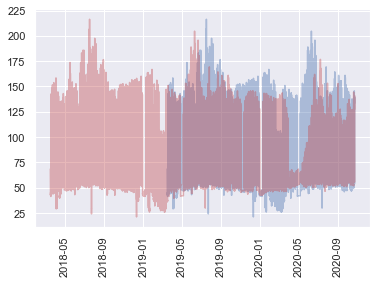

In [111]:
plt.plot(test.index, test['previous_year'], c='b', alpha=0.4)
plt.plot(test.index, test['target'], c='r', alpha=0.4)
plt.xticks(rotation=90);

In [112]:
# удалим пустые значения
test = test.dropna()

In [113]:
print(f'Временной интервал - c {test.index.min()} по {test.index.max()}')

Временной интервал - c 2019-07-07 16:00:00 по 2020-10-22 15:00:00


In [114]:
# отбросим неполные суки наблюдения
test = test['2019-07-18':'2020-10-21']

In [115]:
((test.index[-1] - test.index[0])/np.timedelta64(1, 'M')) # number of months between two dates

15.177587493240791

##### 3.4 Разделение на тренировочный и тестовый датасеты

In [116]:
# разделим данные тренировочный и тестовый датасеты
X_train = test[:'2020-10-20'].drop(['target'], axis = 1)
y_train = test.loc[:'2020-10-20', 'target']

X_test = test['2020-10-21'].drop(['target'], axis = 1)
y_test = test.loc['2020-10-21', 'target']

LR: -11.536894 (37.579437)
KNN: 0.308105 (0.358358)
XGB: 0.458131 (0.482714)
GBR: 0.580456 (0.295394)
RFR: 0.542724 (0.362279)
SVR: 0.117188 (0.366399)
MLP: -15.581907 (60.402326)


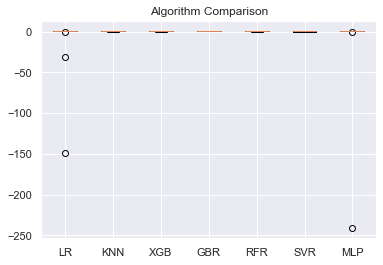

In [117]:
# Быстрая проверка моделей
models = []

models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor())) 
models.append(('XGB', XGBRegressor(random_state=0)))
models.append(('GBR', GradientBoostingRegressor(random_state=0)))
models.append(('RFR', RandomForestRegressor(random_state=0)))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(random_state=0)))

# поочередная оценка моделей
results = []
names = []

for name, model in models:
    # кросс-валидация по временным рядам
    tscv = TimeSeriesSplit(n_splits=15)

    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# сравнение алгоритмов
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [63]:
import math
math.floor(4.7)

4

##### 3.5 Подбор параметров

In [122]:
# побор параметров для XGB
xgb = XGBRegressor(random_state=0)
xgb_param_search = { 
    'n_estimators': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(3,10)]
}

xgb_gsearch = GridSearchCV(estimator=xgb, cv=tscv, param_grid=xgb_param_search, scoring = rmse_score)
xgb_gsearch.fit(X_train, y_train)
print(xgb_gsearch.best_params_)

{'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10}


In [123]:
# побор параметров для GBR
gbr = GradientBoostingRegressor(random_state=0)
gbr_param_search = { 
    'n_estimators': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(3,10)]
}

gbr_gsearch = GridSearchCV(estimator=gbr, cv=tscv, param_grid=gbr_param_search, scoring = rmse_score)
gbr_gsearch.fit(X_train, y_train)
print(gbr_gsearch.best_params_)

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 30}


In [138]:
# побор параметров для RFR
rfr = RandomForestRegressor(random_state=0)
rfr_param_search = { 
    'n_estimators': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(3,10)]
}

rfr_gsearch = GridSearchCV(estimator=rfr, cv=tscv, param_grid=rfr_param_search, scoring = rmse_score)
rfr_gsearch.fit(X_train, y_train)

print(rfr_gsearch.best_params_)

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 30}


Text(0, 0.5, 'RMSE')

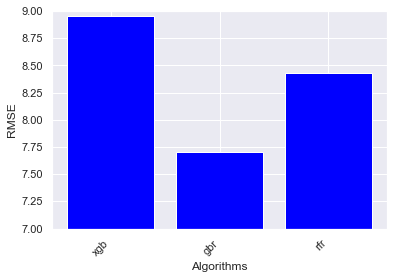

In [169]:
gsearch_res_list = [xgb_gsearch, gbr_gsearch, rfr_gsearch]
# сравнение моделей
def model_selection(gsearch_res_list, X_test):
    res = []
    y_true = y_test.values

    for item in gsearch_res_list:
        y_pred = item.best_estimator_.predict(X_test)
        rmse = regression_results(y_true, y_pred).iloc[-1,0]
        res.append(rmse)
        
    return res

names = ['xgb', 'gbr', 'rfr']
scores = model_selection(gsearch_res_list, X_test)
barlist = plt.bar(np.arange(len(scores)), scores, color='blue', label='алгоритмы')
plt.xticks(np.arange(len(scores)), names, rotation=45, ha='right')
plt.ylim([7., 9.])
plt.xlabel('Algorithms')
plt.ylabel('RMSE')

##### Прогноз на весь день

In [147]:
best_model = gbr_gsearch.best_estimator_

In [148]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

In [149]:
regression_results(y_true, y_pred)

,metrics
explained_variance,0.9611
MAE,4.8053
MSE,59.3470
mean_squared_log_error,0.0038
MAPE,4.1664
r2,0.9429
RMSE,7.7037


##### Выборка результатов за световой день

In [150]:
res = pd.DataFrame({'time':X_test.index, 'pred':y_pred, 'true':y_true})

In [151]:
res = res.set_index('time')

In [152]:
daytime = res.between_time('7:00', '22:00')

In [153]:
regression_results(daytime['true'], daytime['pred'])

,metrics
explained_variance,0.9393
MAE,6.5819
MSE,88.0560
mean_squared_log_error,0.0055
MAPE,5.1717
r2,0.8867
RMSE,9.3838


##### Влияние фичей

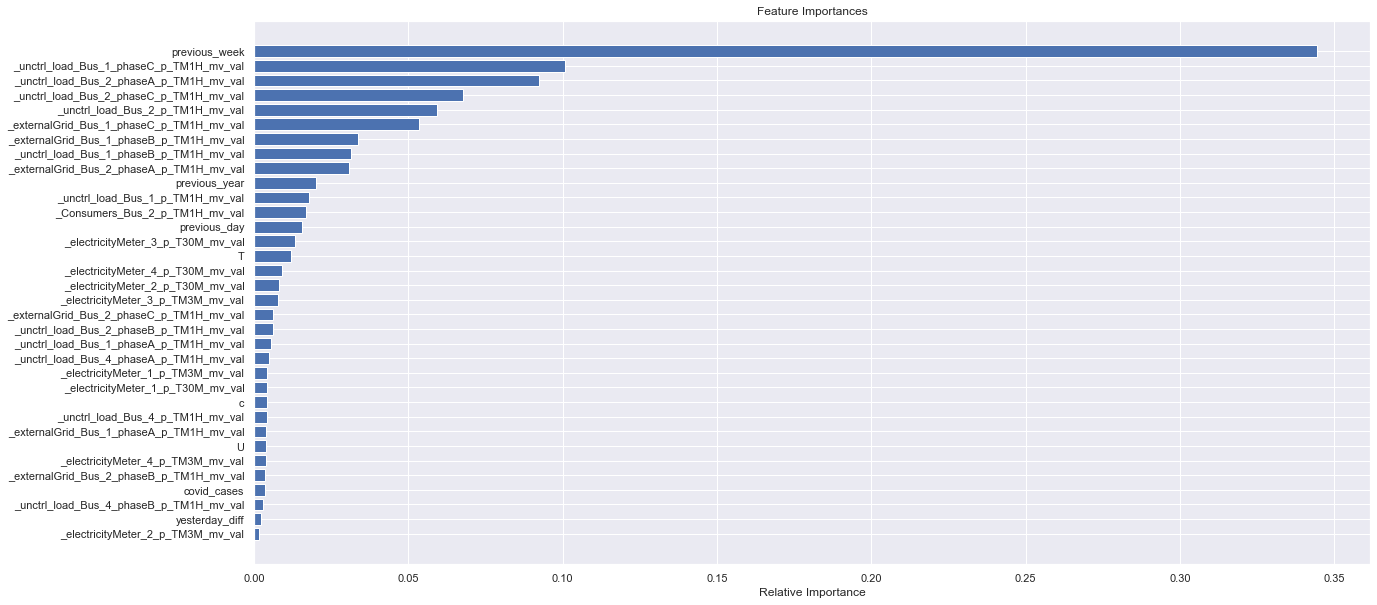

In [154]:
imp = best_model.feature_importances_
plt.figure(figsize=(20,10))
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##### Визуализация

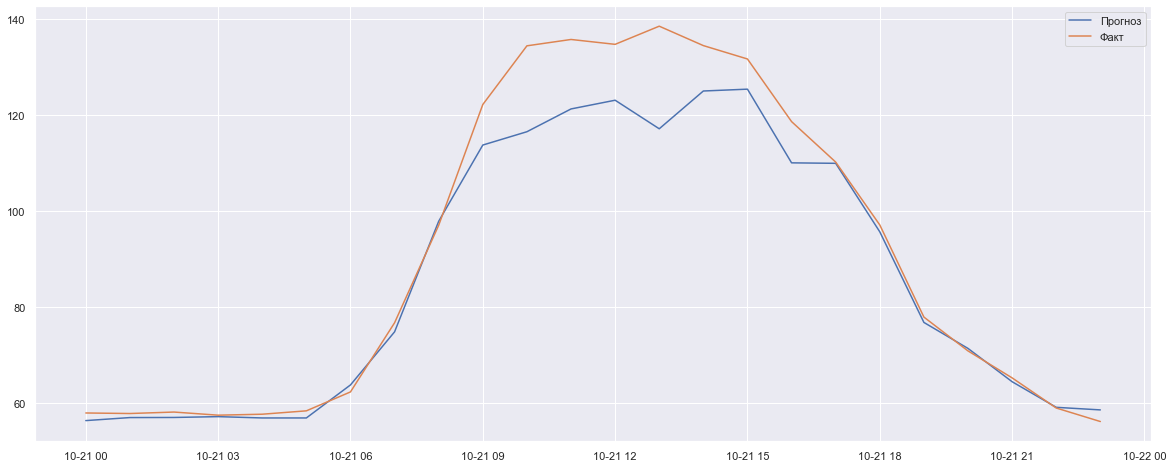

In [159]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(res.index, res['pred'], label='Прогноз')
ax.plot(res.index, res['true'], label='Факт')

plt.legend(loc='upper right')

plt.show()